# 로지스틱 회귀 - pima_indians_diabetes

## 준비작업

In [1]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
import numpy as np

from pandas import DataFrame
from hossam import load_data
import pandas as pd
import statsmodels.api as sm

# 로지스틱 결과 판별 참조 + 머신러닝 라이브러리
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = load_data('pima_indians_diabetes')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/pima_indians_diabetes.xlsx
[desc] 이 데이터 세트는 원래 미국 국립 당뇨병·소화기·신장질환 연구소(National Institute of Diabetes and Digestive and Kidney Diseases)에서 제공한 것입니다. 이 데이터 세트의 목적은 데이터 세트에 포함된 특정 진단 측정값을 기반으로 환자의 당뇨병 여부를 진단적으로 예측하는 것입니다. 더 큰 데이터베이스에서 이러한 사례를 선택하는 데에는 몇 가지 제약 조건이 적용되었습니다. 특히, 여기에 포함된 모든 환자는 21세 이상의 피마 인디언 혈통을 가진 여성입니다. (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

field                     type    description
------------------------  ------  --------------------------------
Pregnancies               연속형  임신횟수
Glucose                   연속형  포도당 부하 검사 수치
BloodPressure             연속형  혈압
SkinThickness             연속형  팔 삼두근 뒤쪽의 피하지방 측정값
Insulin                   연속형  혈청 인슐린
BMI                       연속형  체질량 지수
DiabetesPedigreeFunction  연속형  당뇨 내력 가중치 값
Age                       연속형  나이
Outcome                   명목형  당뇨여부(0 또는 1)

데이터셋 크기: (768, 9)
열 개수: 9
행 개수: 768
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 모델 구축
### 전처리 x(더미처리는 필요)

In [4]:
yname = 'Outcome'

x = origin.drop(yname, axis = 1)
y = origin[yname]

X = sm.add_constant(x)

fit = sm.Logit(y, X).fit()
tbl1 = fit.summary()
print(tbl1)

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                  0.2718
Time:                        11:40:26   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -8.4047      0.717    -11.728      0.000      -9.809

## 결과보고 함수 정의

In [5]:
def logit_report(fit, data, threshold=0.5):
    """
    로지스틱 회귀모형(fit)과 데이터(data)를 받아
    1) 회귀계수표(rdf)
    2) 성능 평가표(cdf)
    3) 모델 요약 문장(result_report)
    4) 모델 보고 문장(model_report)
    5) 변수별 보고 리스트(variable_reports)
    반환하는 함수
    """

    # -----------------------------
    # 1. 성능평가 지표 계산
    # -----------------------------
    yname = fit.model.endog_names
    y_true = data[yname]
    y_prob = fit.predict(fit.model.exog)
    y_pred = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    tpr = recall_score(y_true, y_pred)
    fpr = fp / (fp + tn)
    tnr = 1 - fpr
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    cdf = DataFrame({
        '설명력(P-Rsqe)': [fit.prsquared],
        '정확도(Accuracy)': [acc],
        '정밀도(Precision)': [pre],
        '재현율(Recall, TPR)': [tpr],
        '위양성율(Fallout, FPR)': [fpr],
        '특이성(Specificity, TNR)': [tnr],
        'AUC score': [auc],
        'F1-score': [f1]
    })

    # -----------------------------
    # 2. 회귀계수표 구성 (OR 중심)
    # -----------------------------
    tbl = fit.summary()
    
    # 독립변수 목록 (상수항 제거)
    xnames = [name for name in fit.model.exog_names if name != "const"]
    x = data[xnames]

    # VIF 계산
    vif_dict = {
        col: variance_inflation_factor(x.values, i)
        for i, col in enumerate(x.columns)
    }

    variables = []

    # tbl.tables[1].data[1:] → 첫 행(header) 제거하고 계수 행만 반복
    for row in tbl.tables[1].data[1:]:
        name = row[0].strip()

        # 상수항 제외
        if name not in xnames:
            continue

        beta = float(row[1])
        se   = float(row[2])
        z    = float(row[3])
        p    = float(row[4])

        OR = np.exp(beta)
        CI_low  = np.exp(beta - 1.96 * se)
        CI_high = np.exp(beta + 1.96 * se)

        variables.append({
            "종속변수": yname,
            "독립변수": name,
            "B(베타)": beta,
            "표준오차": se,
            "z": z,
            "p-value": p,
            "OR": OR,
            "CI_lower": CI_low,
            "CI_upper": CI_high,
            "VIF": vif_dict.get(name, np.nan)
        })

    rdf = DataFrame(variables)

    # -----------------------------
    # 3. 모델 요약 문장
    # -----------------------------
    result_report = (
        f"Pseudo R²(McFadden) = {fit.prsquared:.3f}, "
        f"LLR χ²({int(fit.df_model)}) = {fit.llr:.3f}, "
        f"p-value = {fit.llr_pvalue:.4f}, "
        f"Accuracy = {acc:.3f}, "
        f"AUC = {auc:.3f}"
    )

    # -----------------------------
    # 4. 모델 보고 문장
    # -----------------------------
    model_report = (
        f"{yname}에 대하여 {', '.join(xnames)}로 예측하는 로지스틱 회귀분석을 실시한 결과, "
        f"모형은 통계적으로 {'유의' if fit.llr_pvalue <= 0.05 else '유의하지 않은'} "
        f"(LLR χ²({int(fit.df_model)}) = {fit.llr:.3f}, p {'<=' if fit.llr_pvalue <= 0.05 else '>'} 0.05)하였다."
    )

    # -----------------------------
    # 5. 변수별 보고 문장 생성
    # -----------------------------
    variable_reports = []
    template = "%s의 오즈비는 %.3f(p %s 0.05)로, %s 발생 odds에 %s 영향을 미치는 것으로 나타났다."

    for _, row in rdf.iterrows():
        variable_reports.append(
            template % (
                row["독립변수"],
                row["OR"],
                "<=" if row["p-value"] < 0.05 else ">",
                row["종속변수"],
                "유의미한" if row["p-value"] < 0.05 else "유의하지 않은"
            )
        )

    return cdf, rdf, result_report, model_report, variable_reports

## 분석결과 보고

In [6]:
cdf, rdf, r, m, v = logit_report(fit, origin)
display(cdf)
display(rdf)
display(r)
display(m)
display(v)

,설명력(P-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",AUC score,F1-score
0,0.27181,0.782552,0.739336,0.58209,0.11,0.89,0.839425,0.651357


,종속변수,독립변수,B(베타),표준오차,z,p-value,OR,CI_lower,CI_upper,VIF
0,Outcome,Pregnancies,0.1232,0.032,3.840,0.000,1.131111,1.062346,1.204326,3.275748
1,Outcome,Glucose,0.0352,0.004,9.481,0.000,1.035827,1.027738,1.043980,16.725078
2,Outcome,BloodPressure,-0.0133,0.005,-2.540,0.011,0.986788,0.977165,0.996506,14.619512
3,Outcome,SkinThickness,0.0006,0.007,0.090,0.929,1.000600,0.986966,1.014423,4.008696
4,Outcome,Insulin,-0.0012,0.001,-1.322,0.186,0.998801,0.996845,1.000760,2.063689
5,Outcome,BMI,0.0897,0.015,5.945,0.000,1.093846,1.062155,1.126483,18.408884
6,Outcome,DiabetesPedigreeFunction,0.9452,0.299,3.160,0.002,2.573328,1.432126,4.623907,3.195626
7,Outcome,Age,0.0149,0.009,1.593,0.111,1.015012,0.997264,1.033075,13.492985


'Pseudo R²(McFadden) = 0.272, LLR χ²(8) = 270.039, p-value = 0.0000, Accuracy = 0.783, AUC = 0.839'

'Outcome에 대하여 Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age로 예측하는 로지스틱 회귀분석을 실시한 결과, 모형은 통계적으로 유의 (LLR χ²(8) = 270.039, p <= 0.05)하였다.'

['Pregnancies의 오즈비는 1.131(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'Glucose의 오즈비는 1.036(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'BloodPressure의 오즈비는 0.987(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'SkinThickness의 오즈비는 1.001(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.',
 'Insulin의 오즈비는 0.999(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.',
 'BMI의 오즈비는 1.094(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'DiabetesPedigreeFunction의 오즈비는 2.573(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'Age의 오즈비는 1.015(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.']

## AUC 시각화

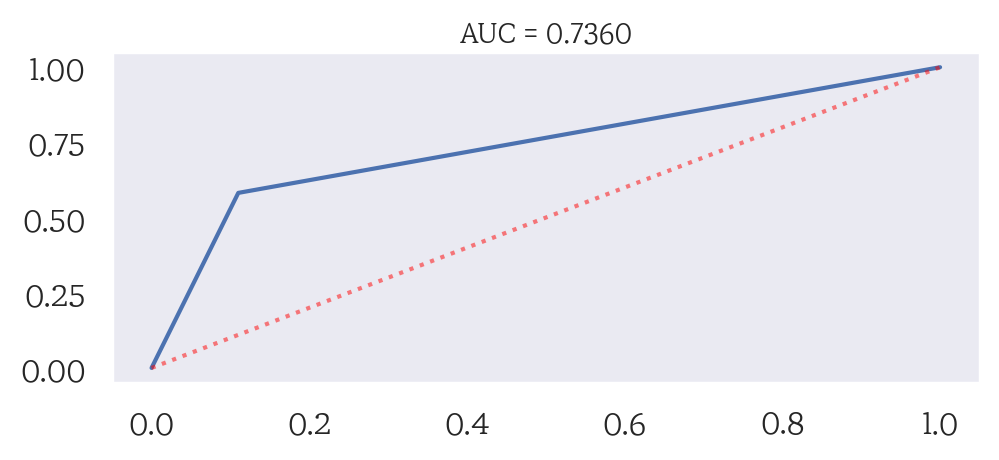

In [7]:
y_true = origin[yname]
y_prob = fit.predict(fit.model.exog)
y_pred = (y_prob >= 0.5).astype(int)

ras = roc_auc_score(y_true, y_pred)

roc_fpr, roc_tpr, thresholds = roc_curve(y_true, y_pred)

width_px = 1000
height_px = 480
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 그래프 그리기, seaborn 사용
sb.lineplot(x= roc_fpr, y = roc_tpr)
sb.lineplot(x= [0,1], y = [0,1], color = 'red', linestyle = ':', alpha = 0.5)

# 그래프 꾸미기
ax.grid(True) # 배경 격자 표시/숨김
ax.set_title(f'AUC = {ras:.4f}', pad = 4, fontsize = 10)


# 출력
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

## 독립변수 로그 변환
### 로그 변환 후 다시 분석

In [9]:
df1 = origin.copy()

# 종속/ 독립변수
yname = 'Outcome'
y = df1[yname]
x = df1.drop(columns = [yname])

# 로그변환 대상 변수 (연속형만)
log_vars = x.columns

# 로그변환(0값 대응)
for v in log_vars:
    df1[f'log_{v}'] = np.log1p(df1[v])

# 원래의 변수 제거
df1.drop(columns = log_vars, inplace = True)

# 로지스틱 회귀
X_log = df1.drop(columns = [yname])
X_input = sm.add_constant(X_log)

fit = sm.Logit(y, X_input).fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.516943
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                  0.2008
Time:                        11:40:29   Log-Likelihood:                -397.01
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 8.305e-39
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -25.6571      2.490    -10.303      0.000

In [10]:
cdf, rdf, r, m, v = logit_report(fit, df1)
display(cdf)
display(rdf)
display(r)
display(m)
display(v)

,설명력(P-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",AUC score,F1-score
0,0.200768,0.769531,0.719807,0.55597,0.116,0.884,0.836187,0.627368


,종속변수,독립변수,B(베타),표준오차,z,p-value,OR,CI_lower,CI_upper,VIF
0,Outcome,log_Pregnancies,0.3125,0.136,2.305,0.021,1.366838,1.047012,1.784360,5.186143
1,Outcome,log_Glucose,2.9775,0.404,7.366,0.000,19.638659,8.896518,43.351443,88.500549
2,Outcome,log_BloodPressure,-0.2716,0.106,-2.562,0.010,0.762159,0.619180,0.938155,25.483998
3,Outcome,log_SkinThickness,0.0359,0.077,0.469,0.639,1.036552,0.891348,1.205410,6.105680
4,Outcome,log_Insulin,-0.0416,0.047,-0.879,0.379,0.959253,0.874835,1.051818,3.618666
5,Outcome,log_BMI,1.9870,0.467,4.253,0.000,7.293620,2.920281,18.216358,59.762583
6,Outcome,log_DiabetesPedigreeFunction,1.6688,0.452,3.689,0.000,5.305797,2.187764,12.867696,4.668408
7,Outcome,log_Age,1.1022,0.342,3.220,0.001,3.010782,1.540150,5.885667,118.849755


'Pseudo R²(McFadden) = 0.201, LLR χ²(8) = 199.460, p-value = 0.0000, Accuracy = 0.770, AUC = 0.836'

'Outcome에 대하여 log_Pregnancies, log_Glucose, log_BloodPressure, log_SkinThickness, log_Insulin, log_BMI, log_DiabetesPedigreeFunction, log_Age로 예측하는 로지스틱 회귀분석을 실시한 결과, 모형은 통계적으로 유의 (LLR χ²(8) = 199.460, p <= 0.05)하였다.'

['log_Pregnancies의 오즈비는 1.367(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'log_Glucose의 오즈비는 19.639(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'log_BloodPressure의 오즈비는 0.762(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'log_SkinThickness의 오즈비는 1.037(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.',
 'log_Insulin의 오즈비는 0.959(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.',
 'log_BMI의 오즈비는 7.294(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'log_DiabetesPedigreeFunction의 오즈비는 5.306(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'log_Age의 오즈비는 3.011(p <= 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.']

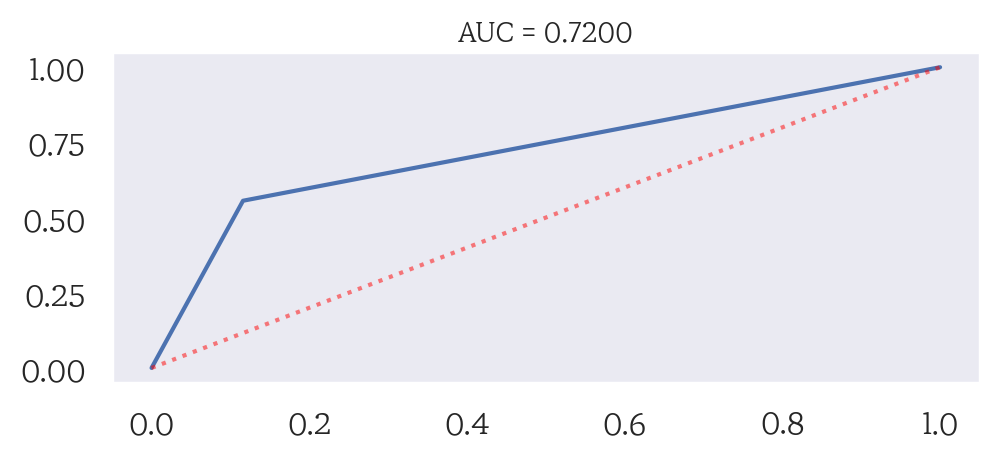

In [ ]:
y_true = df1[yname]
y_prob = fit.predict(fit.model.exog)
y_pred = (y_prob >= 0.5).astype(int)

ras = roc_auc_score(y_true, y_pred)

roc_fpr, roc_tpr, thresholds = roc_curve(y_true, y_pred)

width_px = 1000
height_px = 480
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 그래프 그리기, seaborn 사용
sb.lineplot(x= roc_fpr, y = roc_tpr)
sb.lineplot(x= [0,1], y = [0,1], color = 'red', linestyle = ':', alpha = 0.5)

# 그래프 꾸미기
ax.grid(True) # 배경 격자 표시/숨김
ax.set_title(f'AUC = {ras:.4f}', pad = 4, fontsize = 10)


# 출력
plt.grid()
plt.tight_layout()
plt.show()
plt.close() 

## 로지스틱 회귀(이항분류)
- 사용예시: 금융권 신용도 예측, 의학 분야(질병 발생 확률 예측)

In [22]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
import numpy as np

from pandas import DataFrame, get_dummies
from hossam import load_data
import pandas as pd
import statsmodels.api as sm

# 로지스틱 결과 판별 참조 + 머신러닝 라이브러리
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [13]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [17]:
origin = load_data('graduate')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab12_/graduate.xlsx
[desc] 방사선학 석사과정 대학원생 모집 현황을 조사한 가상의 데이터
[!] Cannot read metadata
데이터셋 크기: (400, 4)
열 개수: 4
행 개수: 400
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   합격여부    400 non-null    int64  
 1   필기점수    400 non-null    int64  
 2   학부성적    400 non-null    float64
 3   병원경력    400 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 12.6+ KB
None


,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,1~5년
1,1,660,3.67,1~5년
2,1,800,4.00,10년 이상
3,1,640,3.19,1년 미만
4,0,520,2.93,1년 미만


In [18]:
origin['병원경력'].unique()

array(['1~5년', '10년 이상', '1년 미만', '5~10년'], dtype=object)

In [20]:
df1 = origin.copy()
df1['병원경력'] = df1['병원경력'].map({'1년 미만': 0, '1~5년':1, '5~10년':2, '10년 이상':3})
df1['병원경력'].unique()

array([1, 3, 0, 2])

In [24]:
df2 = get_dummies(df1, columns = ['병원경력'], dtype = 'int', drop_first = True)
df2.head()

,합격여부,필기점수,학부성적,병원경력_1,병원경력_2,병원경력_3
0,0,380,3.61,1,0,0
1,1,660,3.67,1,0,0
2,1,800,4.00,0,0,1
3,1,640,3.19,0,0,0
4,0,520,2.93,0,0,0


## 로지스틱 회귀 분석

In [26]:
yname = '합격여부'

x = df2.drop(yname, axis=1)
y = df2[yname]

X = sm.add_constant(x)
display(X)

fit = sm.Logit(y, X).fit()
tbl1 = fit.summary()
print(tbl1)

,const,필기점수,학부성적,병원경력_1,병원경력_2,병원경력_3
0,1.0,380,3.61,1,0,0
1,1.0,660,3.67,1,0,0
2,1.0,800,4.00,0,0,1
3,1.0,640,3.19,0,0,0
4,1.0,520,2.93,0,0,0
...,...,...,...,...,...,...
395,1.0,620,4.00,0,1,0
396,1.0,560,3.04,1,0,0
397,1.0,460,2.63,0,1,0
398,1.0,700,3.65,0,1,0


Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   합격여부   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                   화, 16 12 2025   Pseudo R-squ.:                 0.08292
Time:                        13:10:05   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 7.578e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5414      1.138     -4.869      0.000      -7.772      -3.311
필기점수           0.0023      0.

## 이진분류의 평가
### 혼동행렬

In [27]:
y_true = df2['합격여부']
y_true

0      0
1      1
2      1
3      1
4      0
      ..
395    0
396    0
397    0
398    0
399    0
Name: 합격여부, Length: 400, dtype: int64

### 로지스틱이 예측한 값
#### 1일 확률을 의미함

In [28]:
y_pred = fit.predict(X)
y_pred

0      0.172627
1      0.292175
2      0.738408
3      0.178385
4      0.118354
         ...   
395    0.488670
396    0.165504
397    0.181062
398    0.463667
399    0.300731
Length: 400, dtype: float64

#### 혼동행렬을 구하기 위해 예측 결과를 이진값으로 변환
- 50% 초과 -> True, 아니면 False

In [29]:
y_pred_fix = y_pred > 0.5
y_pred_fix

0      False
1      False
2       True
3      False
4      False
       ...  
395    False
396    False
397    False
398    False
399    False
Length: 400, dtype: bool

#### 혼동행렬

In [30]:
cm = confusion_matrix(y_true, y_pred_fix)
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp

(np.int64(254), np.int64(19), np.int64(97), np.int64(30))

#### 혼동행렬을 DataFrame으로 변환

In [33]:
cmdf = DataFrame(cm, index = ['Actual 0 (TN/FP)', 'Actual 1 (FN/TP)'], columns = ['Predicted (Negative)', 'Predicted (Positive)'])
cmdf

,Predicted (Negative),Predicted (Positive)
Actual 0 (TN/FP),254,19
Actual 1 (FN/TP),97,30


#### 혼동행렬 히트맵

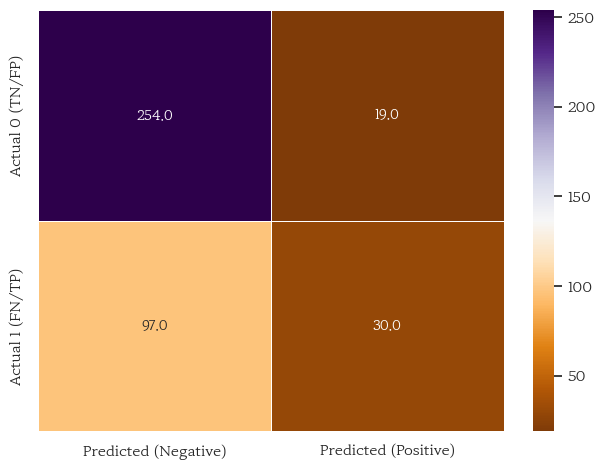

In [35]:
width_px = 1200
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)

# lmplot 그리기
sb.heatmap(data=cmdf,annot = True, fmt = '0.1f', linewidth = 0.5, cmap = 'PuOr') # col, row 선택사항

ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()

# 출력
plt.tight_layout()
plt.show()
plt.close()

## 정확도 구하기

In [36]:
acc = accuracy_score(y_true, y_pred_fix)
acc

0.71

## 정밀도 구하기

In [37]:
pre = precision_score(y_true, y_pred_fix)
pre

0.6122448979591837

## 재현율 구하기

In [38]:
recall = tp/ (tp + fn)
recall = recall_score(y_true, y_pred_fix)
recall

0.23622047244094488

## 위양성율, 거짓 양성 비율(Fallout, FPR)


In [39]:
fpr = fp / (fp+ tn)
fpr

np.float64(0.0695970695970696)

## 특이성

In [40]:
tnr = 1 - fpr
tnr

np.float64(0.9304029304029304)

## F1 score

In [43]:
f1 = f1_score(y_true, y_pred_fix)
f1

0.3409090909090909

## ROC Curve

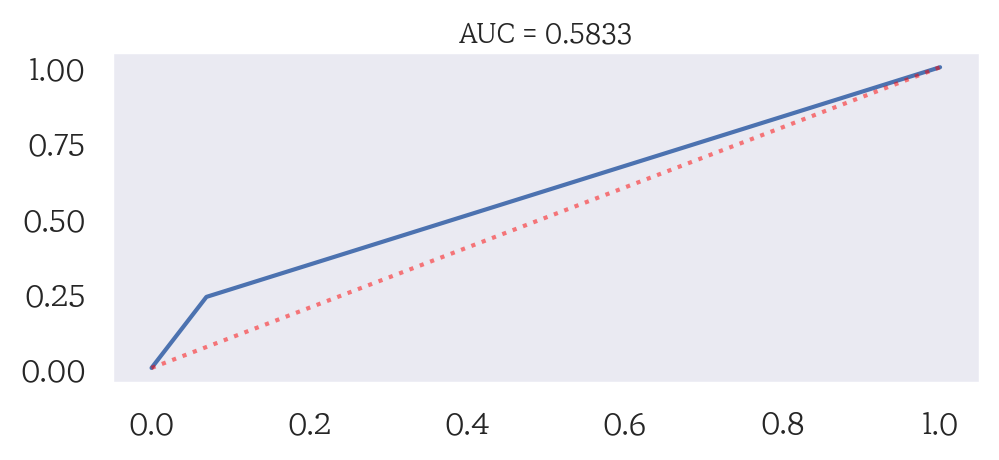

In [45]:
ras = roc_auc_score(y_true, y_pred_fix)

roc_fpr, roc_tpr, thresholds = roc_curve(y_true, y_pred_fix)

width_px = 1000
height_px = 480
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 그래프 그리기, seaborn 사용
sb.lineplot(x= roc_fpr, y = roc_tpr)
sb.lineplot(x= [0,1], y = [0,1], color = 'red', linestyle = ':', alpha = 0.5)

# 그래프 꾸미기
ax.grid(True) # 배경 격자 표시/숨김
ax.set_title(f'AUC = {ras:.4f}', pad = 4, fontsize = 10)


# 출력
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

In [49]:
result_df = DataFrame({
    '설명력(P-Rsqe)': [fit.prsquared],
    '정확도(Accuracy)': [acc],
    '정밀도(Precision)': [pre],
    '재현율(Recall, TPR)': [recall],
    '위양성율(Fallout, FPR)': [fpr],
    '특이성(Specificity, TNR)': [tnr],
    'RAS':[ras],   
    'F1-score': [f1]
})
result_df

,설명력(P-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",RAS,F1-score
0,0.082922,0.71,0.612245,0.23622,0.069597,0.930403,0.583312,0.340909


## 오즈비 또는 승산비 구하기
### 계수 추출

In [50]:
coef = fit.params
coef

const    -5.541443
필기점수      0.002264
학부성적      0.804038
병원경력_1    0.211260
병원경력_2    0.876021
병원경력_3    1.551464
dtype: float64

### 오즈 구하기

In [51]:
odds_rate = np.exp(coef)
odds_rate_df = DataFrame(odds_rate, columns = ['odds_rate'])
odds_rate_df

,odds_rate
const,0.003921
필기점수,1.002267
학부성적,2.234545
병원경력_1,1.235233
병원경력_2,2.401325
병원경력_3,4.718371


### 오즈비

In [53]:
odds_ratio = (tp * tn) / (fp * fn)
odds_ratio

np.float64(4.134563212154097)

### 가상 데이터를 통한 예측

In [57]:
myinput = '480, 4.3, 0,0,1'
myinput = myinput.split(',')

x_new = DataFrame([{
    '필기점수': int(myinput[0].strip()),
    '학부성적': float(myinput[1].strip()),
    '병원경력_1': int(myinput[2].strip()),
    '병원경력_2': int(myinput[3].strip()),
    '병원경력_3': int(myinput[4].strip())
}])

x_new_input = sm.add_constant(x_new, has_constant = 'add')
myresult = fit.predict(x_new_input)
myresult

0    0.635134
dtype: float64

In [58]:
'당신의 합격 확률은 {0:0.2f}% 입니다.'.format(myresult[0]*100)

'당신의 합격 확률은 63.51% 입니다.'

In [59]:
'합격' if myresult[0] > 0.5 else '불합격'

'합격'